# Panel Data for Banking Sector Analysis
## Jeff Wooldridge
### Michigan State University

#### Workings by Martien Lubberink

**Just scroll down to find the answers in bold**

In [1]:
# Some shots accross the bow
import os
import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthEnd
import statsmodels.formula.api as sm
import statsmodels.api as smpp
from linearmodels.panel import PanelOLS
from linearmodels.panel import FamaMacBeth
from linearmodels.panel import PooledOLS
from linearmodels.panel import BetweenOLS
from linearmodels.panel import RandomEffects
from linearmodels.panel import FirstDifferenceOLS
from linearmodels.panel import compare
import random
import math
from datetime import datetime
import seaborn as sns
pd.options.display.float_format = '{:,.2f}'.format
print('Pandas:   %s.' % pd.__version__)
print('Numpy:   %s.' % np.__version__)
import linearmodels
print('Linearmodels by Kevin Sheppard:   %s.' % linearmodels.__version__)
df = pd.read_stata("bankmonetary.dta")

Pandas:   1.2.3.
Numpy:   1.19.2.
Linearmodels by Kevin Sheppard:   4.22.


Set time series and ids for panel data:

In [2]:
df['date'] = pd.to_datetime(df.year, format='%Y').dt.normalize()
df['date'] = df['date'] + MonthEnd(12)   # df['date'] = df['date'].dt.date
df.set_index(['id', 'date'], inplace=True)

# Generate dummies based on year
dd = pd.get_dummies(df.year, prefix='year', drop_first=True)

# Add a constant
ddc = smpp.add_constant(dd)

<AxesSubplot:xlabel='year', ylabel='nim'>

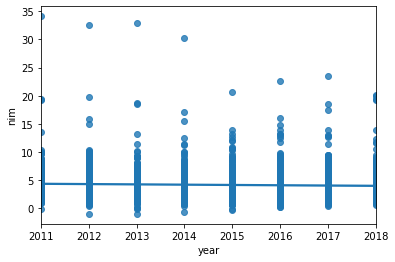

In [3]:
# where are we looking at, part I
sns.regplot(data=df, x="year", y="nim", robust=True)

<AxesSubplot:xlabel='monpol', ylabel='nim'>

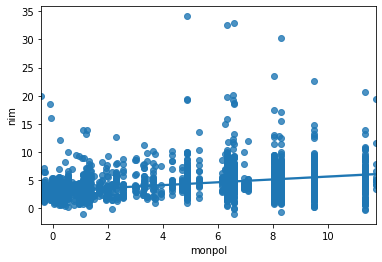

In [4]:
# where are we looking at, part II
sns.regplot(data=df, x="monpol", y="nim", robust=True)

In [5]:
# where are we looking at, part III
full_vars = ['nim', 'monpol', 'variation', 'liquidity', 'size', 'fin_dev', 'equity_g', 'EU', 'dindmp']
df[full_vars].head()

nim  monpol  variation  liquidity  size  fin_dev  \
id      date                                                           
4162620 2011-12-31 4.37    2.15       0.09      21.14 21.64    66.00   
        2012-12-31 3.73    1.12       0.50      19.35 21.59    66.90   
        2013-12-31 3.79    0.57       0.08      20.18 21.54    67.10   
        2014-12-31 4.00    0.45       0.41      28.30 21.55    60.80   
        2015-12-31 3.46    0.25       0.59      35.62 21.66    56.50   

                    equity_g  EU  dindmp  
id      date                              
4162620 2011-12-31    -11.11   1       0  
        2012-12-31      7.25   1       0  
        2013-12-31     42.28   1       0  
        2014-12-31      6.22   1       0  
        2015-12-31    -11.72   1       0

In [6]:
# where are we looking at, part IV
df[full_vars].describe()

,nim,monpol,variation,liquidity,size,fin_dev,equity_g,EU,dindmp
count,"1,888.00","1,888.00","1,888.00","1,888.00","1,888.00","1,888.00","1,888.00","1,888.00","1,888.00"
mean,4.50,4.44,0.21,37.10,18.96,53.60,4.29,0.31,0.28
std,3.01,3.67,0.37,19.39,1.99,8.83,15.75,0.46,0.45
min,-1.03,-0.42,0.00,1.50,13.16,26.60,-35.79,0.00,0.00
25%,2.64,0.78,0.05,23.87,17.53,47.20,-6.65,0.00,0.00
50%,3.96,4.89,0.09,32.74,18.79,54.70,2.65,0.00,0.00
75%,5.63,6.95,0.25,46.49,20.47,59.50,12.39,1.00,1.00
max,34.12,11.73,2.68,98.85,24.02,85.40,52.55,1.00,1.00


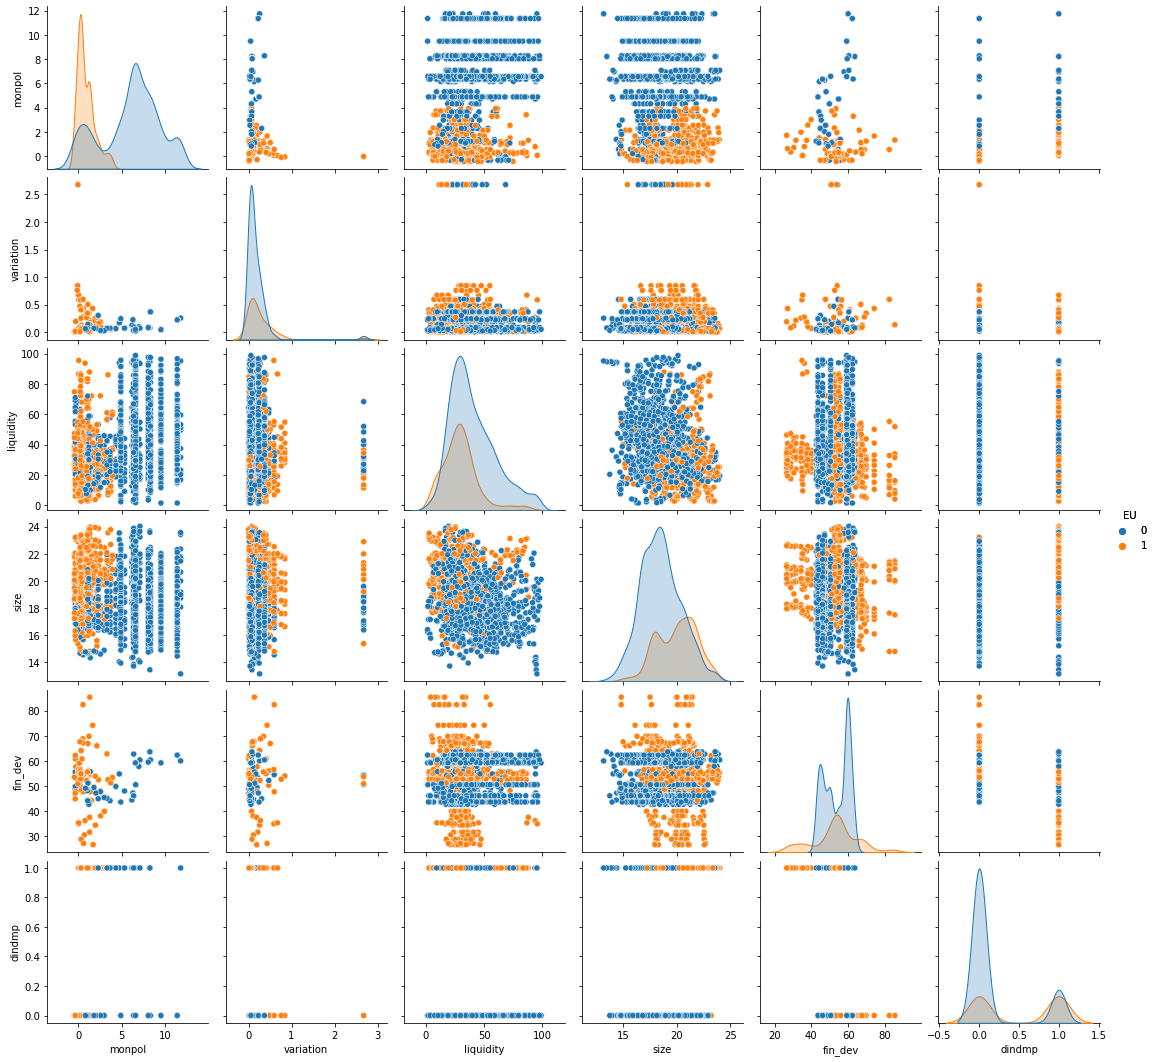

In [7]:
# where are we looking at, part V
g = sns.pairplot(df[['monpol', 'variation', 'liquidity', 'size', 'fin_dev', 'EU', 'dindmp']], hue="EU")
# g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

In [8]:
# These functions do most of the hard work

def homework(dfy, dfr, tests, cov_type="unadjusted", cluster_entity=False, cluster_time=False):
    # P OLS
    cdic = {}
    if 'ols' in tests:
        try:
            mod = PooledOLS(dfy, dfr)
            pooled_res = mod.fit(cov_type=cov_type, cluster_entity=cluster_entity, cluster_time=cluster_time)
            print(pooled_res)
            cdic["POLS"] = pooled_res
            # pooled_res.resids.hist(bins=50)
        except Exception:
            pass
    # RE
    if 're' in tests:
        try:
            mod = RandomEffects(dfy, dfr)
            re_res = mod.fit(cov_type=cov_type, cluster_entity=cluster_entity, cluster_time=cluster_time)
            print(re_res)
            var_decomp = re_res.variance_decomposition.values
            print(f"Sigma_u: {var_decomp[0]**0.5:3.4f}")
            print(f"Sigma_e: {var_decomp[1]**0.5:3.4f}")
            print(f"rho: {var_decomp[2]:3.4f}")
            print(f"Theta: {re_res.theta.mean()[0]:3.4f}")
            cdic["RE"] = re_res
        except Exception:
            pass
    # FD
    if 'fd' in tests:
        try:
            mod = FirstDifferenceOLS(dfy, dfr[[x for x in dfr if x!='const']])
            # fd_res = mod.fit(cov_type=cov_type, cluster_entity=cluster_entity, cluster_time=cluster_time)
            fd_res = mod.fit()
            print(fd_res)
            cdic["FD"] = fd_res
        except Exception:
            pass
    # FE
    if 'fe' in tests:
        try:
            mod = PanelOLS(dfy, dfr, entity_effects=True, time_effects=False, drop_absorbed=True)
            fe_res = mod.fit(cov_type=cov_type, cluster_entity=cluster_entity, cluster_time=cluster_time)
            print(fe_res)
            cdic["FE"] = fe_res
        except Exception:
            pass
    # https://bashtage.github.io/linearmodels/iv/iv/linearmodels.iv.results.compare.html?highlight=compare#linearmodels.iv.results.compare
    #for i in ['pvalues', 'std-errors']:
    for i in ['std-errors']:
        if len(tests) > 1:
            print(compare(cdic, precision=i))
    return cdic


def parameter_plot(d_item, which_param):
    par_plot = pd.DataFrame()
    for key, value in d_item.items():
        serie = eval("d_item[key]." + which_param)
        serie.name = key
        par_plot = par_plot.append(serie.to_frame().T)
    return par_plot.T


def cross_compare(d_item_1, which_est_1, d_item_2, which_est_2, which_param):
    s1 = eval("d_item_1[which_est_1]." + which_param)
    s1.name = which_est_1
    s2 = eval("d_item_2[which_est_2]." + which_param)
    s2.name = which_est_2
    return s1.to_frame().join(s2, rsuffix='_bis')

### i) What do you conclude about the coefficients on the seven year dummies?

In [9]:
hw_1  = homework(df['nim'], ddc, ['ols','re','fd','fe'])

                          PooledOLS Estimation Summary                          
Dep. Variable:                    nim   R-squared:                        0.0014
Estimator:                  PooledOLS   R-squared (Between):              0.0000
No. Observations:                1888   R-squared (Within):               0.0080
Date:                Mon, Mar 15 2021   R-squared (Overall):              0.0014
Time:                        19:31:15   Log-likelihood                   -4759.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      0.3785
Entities:                         236   P-value                           0.9153
Avg Obs:                       8.0000   Distribution:                  F(7,1880)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             0.3785
                            

**As the comparison shows, the coefficents are all the same.**

Let's plot the coefficients

So, this is how it looks like in pictures:

<AxesSubplot:ylabel='Coefficients'>

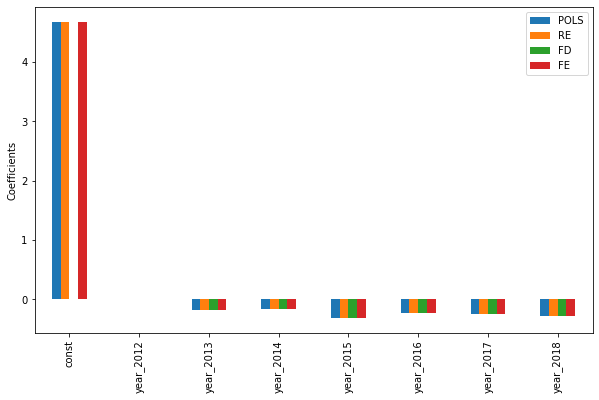

In [10]:
parameter_plot(hw_1, 'params').plot(figsize = (10,6), kind = 'bar', ylabel = 'Coefficients')

But standard errors vary:

<AxesSubplot:xlabel='No clustering', ylabel='Standard errors'>

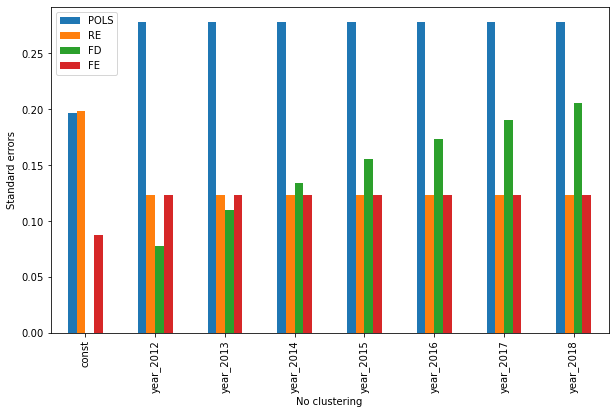

In [11]:
parameter_plot(hw_1, 'std_errors').plot(figsize = (10,6), kind = 'bar', ylabel = 'Standard errors', xlabel = 'No clustering')

### ii) Add the time-constant variables EU and disdmp to the model and estimate it by POLS and RE. How do the coefficients compare? 

In [12]:
hw_2 = homework(df['nim'], df[['EU', 'dindmp']].join(ddc), ['ols','re'])

                          PooledOLS Estimation Summary                          
Dep. Variable:                    nim   R-squared:                        0.1227
Estimator:                  PooledOLS   R-squared (Between):              0.1470
No. Observations:                1888   R-squared (Within):               0.0080
Date:                Mon, Mar 15 2021   R-squared (Overall):              0.1227
Time:                        19:31:15   Log-likelihood                   -4637.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      29.185
Entities:                         236   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                  F(9,1878)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             29.185
                            

**Again, all coefficients are the same.**

**FE fails to return coefficents on `EU` and `dindmp`.**

### iii) Are the POLS and RE standard errors from part (ii) the same? Why or why not?

Let's take a look at the standard errors:

<AxesSubplot:xlabel='No clustering', ylabel='Standard errors'>

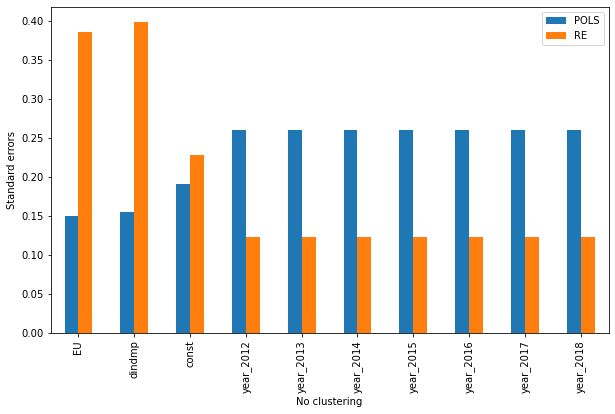

In [13]:
parameter_plot(hw_2, 'std_errors').plot(figsize = (10,6), kind = 'bar', ylabel = 'Standard errors', xlabel='No clustering')

**The RE standard errors differ from those of OLS, likely caused by unobserved bank-specific effects *between* and *within* banks. Looking at \rho (0.78), it appears as if the bank effects dominate the idiosyncratic errors.** 

### (iv) Obtain the cluster-robust standard errors for POLS. Do you prefer these or the usual RE standard errors?

In [14]:
hw_4a = homework(df['nim'], df[['EU', 'dindmp']].join(ddc), ['ols'], 'clustered', True, False)
hw_4b = homework(df['nim'], df[['EU', 'dindmp']].join(ddc), ['re'])

                          PooledOLS Estimation Summary                          
Dep. Variable:                    nim   R-squared:                        0.1227
Estimator:                  PooledOLS   R-squared (Between):              0.1470
No. Observations:                1888   R-squared (Within):               0.0080
Date:                Mon, Mar 15 2021   R-squared (Overall):              0.1227
Time:                        19:31:16   Log-likelihood                   -4637.4
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      29.185
Entities:                         236   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                  F(9,1878)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             7.6502
                            

This is how the standard errors look:

<AxesSubplot:xlabel='OLS: cluster-robust se, RE usual se', ylabel='Standard errors'>

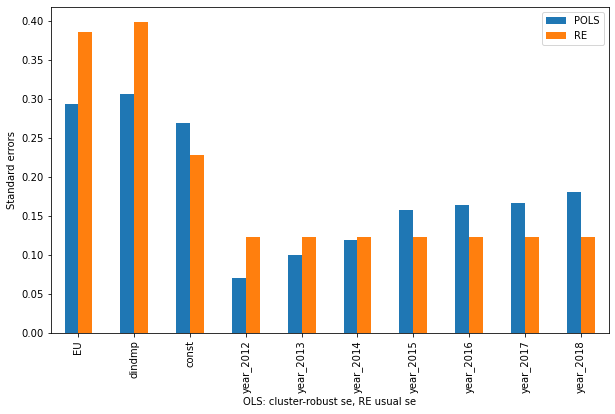

In [15]:
cross_compare(hw_4a, 'POLS', hw_4b, 'RE', 'std_errors').plot(figsize = (10,6), kind = 'bar', ylabel = 'Standard errors', xlabel = 'OLS: cluster-robust se, RE usual se')

**We should generally prefer RE, because it aknowledges some of the correlations between banks. Also RE is usually less biased. On the other hand, the clustered se's from OLS take care of serial correlation, and the standard errors are noticably different from the unclusrered OLS results.** 

**This is a tricky comparison!**

<AxesSubplot:ylabel='Coefficients'>

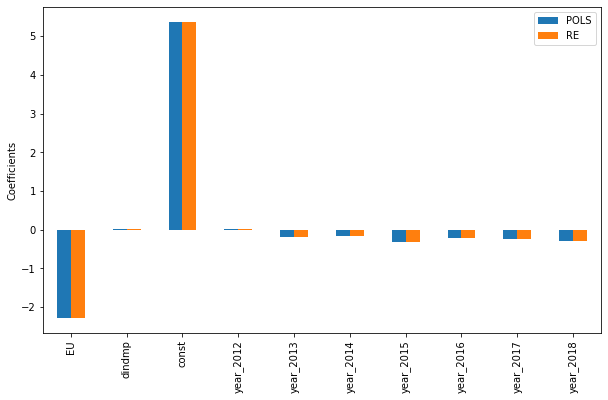

In [16]:
# If you want to check coefficients ...
cross_compare(hw_4a, 'POLS', hw_4b, 'RE', 'params').plot(figsize = (10,6), kind = 'bar', ylabel = 'Coefficients')

### (v) Obtain the fully robust RE standard errors. How do these compare with the fully robust POLS standard errors, and why?

In [17]:
hw_5 = homework(df['nim'], df[['EU', 'dindmp']].join(ddc), ['ols','re'], 'clustered', True, False)

                          PooledOLS Estimation Summary                          
Dep. Variable:                    nim   R-squared:                        0.1227
Estimator:                  PooledOLS   R-squared (Between):              0.1470
No. Observations:                1888   R-squared (Within):               0.0080
Date:                Mon, Mar 15 2021   R-squared (Overall):              0.1227
Time:                        19:31:16   Log-likelihood                   -4637.4
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      29.185
Entities:                         236   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                  F(9,1878)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             7.6502
                            

<AxesSubplot:xlabel='POLS and RE clustered by id.', ylabel='Standard errors'>

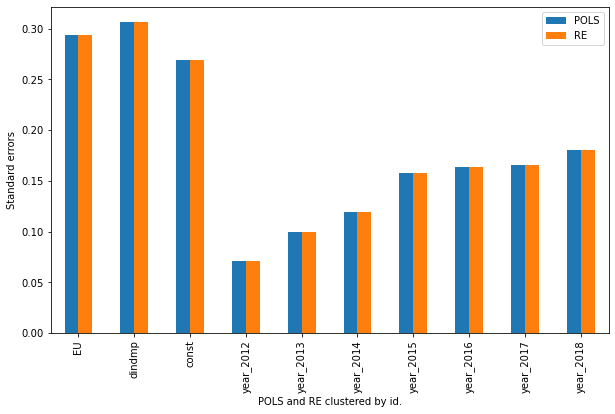

In [18]:
parameter_plot(hw_5, 'std_errors').plot(figsize = (10,6), kind = 'bar', ylabel = 'Standard errors', xlabel =  'POLS and RE clustered by id.')

**These are the same, likely because of the dummy variables, all unexplained variance ends up in the error term, ie:**

$$Var(c_i) = 0$$

### Now estimate the equation using this list of variables, random effects:

In [19]:
varlyst = ['monpol', 'variation', 'liquidity', 'size', 'fin_dev', 'equity_g', 'EU', 'dindmp']

### vi) How do the nonrobust and robust standard errors generally compare?

In [20]:
hw_61_NR = homework(df['nim'], smpp.add_constant(df[varlyst]), ['re'])

                        RandomEffects Estimation Summary                        
Dep. Variable:                    nim   R-squared:                        0.1013
Estimator:              RandomEffects   R-squared (Between):              0.1852
No. Observations:                1888   R-squared (Within):               0.0869
Date:                Mon, Mar 15 2021   R-squared (Overall):              0.1680
Time:                        19:31:17   Log-likelihood                   -3164.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      26.476
Entities:                         236   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                  F(8,1879)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             26.476
                            

In [21]:
hw_61_RE = homework(df['nim'], smpp.add_constant(df[varlyst]), ['re'], 'clustered', True)

                        RandomEffects Estimation Summary                        
Dep. Variable:                    nim   R-squared:                        0.1013
Estimator:              RandomEffects   R-squared (Between):              0.1852
No. Observations:                1888   R-squared (Within):               0.0869
Date:                Mon, Mar 15 2021   R-squared (Overall):              0.1680
Time:                        19:31:17   Log-likelihood                   -3164.6
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      26.476
Entities:                         236   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                  F(8,1879)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             12.438
                            

### What is the estimated value of theta, the quasi-time-demeaning parameter?
**See above, it is fairly close to 1, indicating the bank-specific effects are correleated with the regressors. *nim* is only quasi demeaned.**

### How do the nonrobust and robust standard errors generally compare? 
**See below. These are similar (ignoring the constant). Does this mean that serial correlation is not a big worry?**

<AxesSubplot:xlabel='RE: usual se, RE_bis: clustered', ylabel='Standard errors'>

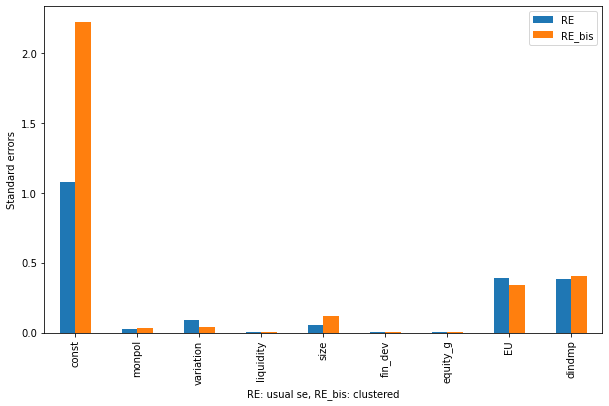

In [22]:
cross_compare(hw_61_NR, 'RE', hw_61_RE, 'RE', 'std_errors').plot(figsize = (10,6), kind = 'bar', ylabel = 'Standard errors', xlabel = 'RE: usual se, RE_bis: clustered')

### (vii) Now estimate the equation by fixed effects, include the full set of time dummies to reflect the different intercepts

In [23]:
hw_7_NR = homework(df['nim'], df[varlyst[:-2]].join(dd), ['fe'])

                          PanelOLS Estimation Summary                           
Dep. Variable:                    nim   R-squared:                        0.1000
Estimator:                   PanelOLS   R-squared (Between):             -11.189
No. Observations:                1888   R-squared (Within):               0.1000
Date:                Mon, Mar 15 2021   R-squared (Overall):             -10.578
Time:                        19:31:17   Log-likelihood                   -3016.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      14.007
Entities:                         236   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                 F(13,1639)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             14.007
                            

In [24]:
hw_7_FE = homework(df['nim'], df[varlyst[:-2]].join(dd), ['fe'], 'clustered', True)

                          PanelOLS Estimation Summary                           
Dep. Variable:                    nim   R-squared:                        0.1000
Estimator:                   PanelOLS   R-squared (Between):             -11.189
No. Observations:                1888   R-squared (Within):               0.1000
Date:                Mon, Mar 15 2021   R-squared (Overall):             -10.578
Time:                        19:31:17   Log-likelihood                   -3016.5
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      14.007
Entities:                         236   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                 F(13,1639)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             4.5566
                            

<AxesSubplot:xlabel='RE and FE: non clustered se', ylabel='Standard errors'>

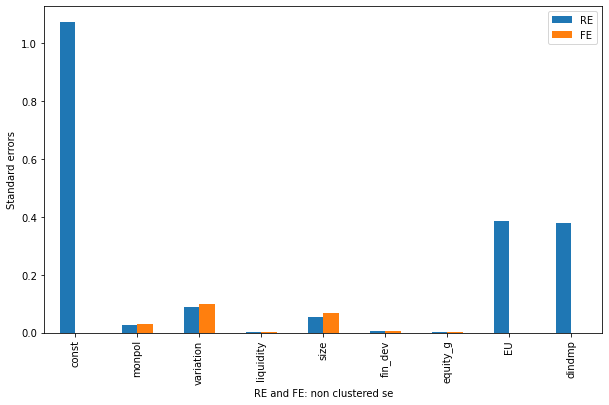

In [25]:
cross_compare(hw_61_NR, 'RE', hw_7_NR, 'FE', 'std_errors').plot(figsize = (10,6), kind = 'bar', ylabel = 'Standard errors', xlabel = 'RE and FE: non clustered se')

<AxesSubplot:xlabel='RE and FE: clustered se', ylabel='Standard errors'>

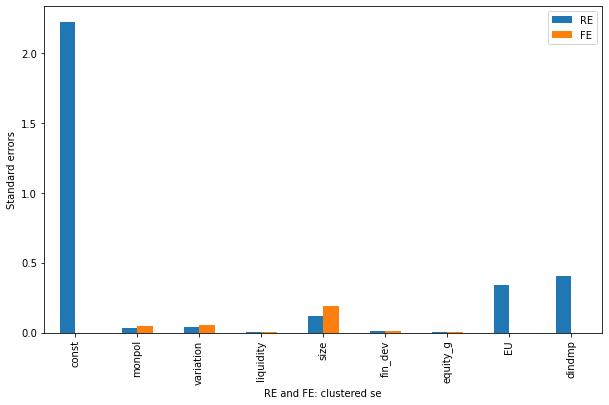

In [26]:
cross_compare(hw_61_RE, 'RE', hw_7_FE, 'FE', 'std_errors').plot(figsize = (10,6), kind = 'bar', ylabel = 'Standard errors', xlabel = 'RE and FE: clustered se')

 ### How do the estimates of  beta 1 and beta 2 compare with those in part (vi)?

In [27]:
print(f"RE nc,    beta 1 (monpol): {hw_61_NR['RE'].params[1]:3.4f}  beta 2 (variation): {hw_61_NR['RE'].params[2]:3.4f}")
print(f"RE clust, beta 1 (monpol): {hw_61_RE['RE'].params[1]:3.4f}  beta 2 (variation): {hw_61_RE['RE'].params[2]:3.4f}")
print("\n")
print(f"FE nc,    beta 1 (monpol): {hw_7_NR['FE'].params[0]:3.4f}  beta 2 (variation): {hw_7_NR['FE'].params[1]:3.4f}")
print(f"FE clust, beta 1 (monpol): {hw_7_FE['FE'].params[0]:3.4f}  beta 2 (variation): {hw_7_FE['FE'].params[1]:3.4f}")

RE nc,    beta 1 (monpol): 0.0850  beta 2 (variation): -0.0717
RE clust, beta 1 (monpol): 0.0850  beta 2 (variation): -0.0717


FE nc,    beta 1 (monpol): 0.0735  beta 2 (variation): 0.0804
FE clust, beta 1 (monpol): 0.0735  beta 2 (variation): 0.0804


**The coefficients on *monpol* are similar. However, the one on the variation of the interbank rates differs markedly: in sign and significance.** 

### (viii) Use the egen command to obtain the time averages.

**I demeaned by year, beause it gaive the same coefficents, also in Stata.**

In [28]:
### Demean by year
dfgp = df.groupby('year')
dfm  = dfgp[varlyst].transform('mean')
dfdm =   df[varlyst] - dfm  # dfdm.to_clipboard()

In [29]:
### Demean by bank
dfgp_bk = df.groupby('id')
dfm_bk  = dfgp_bk[varlyst].transform('mean')
dfdm_bk =   df[varlyst] - dfm_bk  # dfdm_bk.to_clipboard()

In [30]:
# dfdm.head() 

In [31]:
# dfdm.tail()

In [32]:
# Check
dfdm.mean()

monpol       0.00
variation    0.00
liquidity    0.00
size        -0.00
fin_dev      0.00
equity_g    -0.00
EU          -0.00
dindmp      -0.00
dtype: float64

In [33]:
# where are we looking at
# g = sns.pairplot(df['nim'].to_frame().join(dfdm[varlyst[:-2]]).join(df['EU']), hue = 'EU')
# g.map_offdiag(sns.scatterplot)

In [34]:
data_8 = smpp.add_constant(df[varlyst].join(dfdm[varlyst[:-2]].add_suffix('_d'))).copy()  # data_8.to_clipboard()
data_8.head()

const  monpol  variation  liquidity  size  fin_dev  \
id      date                                                             
4162620 2011-12-31   1.00    2.15       0.09      21.14 21.64    66.00   
        2012-12-31   1.00    1.12       0.50      19.35 21.59    66.90   
        2013-12-31   1.00    0.57       0.08      20.18 21.54    67.10   
        2014-12-31   1.00    0.45       0.41      28.30 21.55    60.80   
        2015-12-31   1.00    0.25       0.59      35.62 21.66    56.50   

                    equity_g  EU  dindmp  monpol_d  variation_d  liquidity_d  \
id      date                                                                   
4162620 2011-12-31    -11.11   1       0     -1.64        -0.09       -13.91   
        2012-12-31      7.25   1       0     -3.07         0.32       -15.28   
        2013-12-31     42.28   1       0     -3.35        -0.00       -14.82   
        2014-12-31      6.22   1       0     -4.25         0.11        -5.80   
        2015-12-31    -11.72   1       0     -5.67         0.01        -1.54   

                    size_d  fin_dev_d  equity_g_d  
id      date                                       
4162620 2011-12-31    2.88      15.89        6.85  
        2012-12-31    2.62      15.90       -1.00  
        2013-12-31    2.53      14.82       38.00  
        2014-12-31    2.68       4.71        4.57  
        2015-12-31    2.78       0.15      -23.90

In [35]:
data_8nc = df[varlyst[:-2]].join(dfdm[varlyst[:-2]].add_suffix('_d')).copy()  # data_8nc.to_clipboard()
data_8nc.head()

monpol  variation  liquidity  size  fin_dev  equity_g  \
id      date                                                                
4162620 2011-12-31    2.15       0.09      21.14 21.64    66.00    -11.11   
        2012-12-31    1.12       0.50      19.35 21.59    66.90      7.25   
        2013-12-31    0.57       0.08      20.18 21.54    67.10     42.28   
        2014-12-31    0.45       0.41      28.30 21.55    60.80      6.22   
        2015-12-31    0.25       0.59      35.62 21.66    56.50    -11.72   

                    monpol_d  variation_d  liquidity_d  size_d  fin_dev_d  \
id      date                                                                
4162620 2011-12-31     -1.64        -0.09       -13.91    2.88      15.89   
        2012-12-31     -3.07         0.32       -15.28    2.62      15.90   
        2013-12-31     -3.35        -0.00       -14.82    2.53      14.82   
        2014-12-31     -4.25         0.11        -5.80    2.68       4.71   
        2015-12-31     -5.67         0.01        -1.54    2.78       0.15   

                    equity_g_d  
id      date                    
4162620 2011-12-31        6.85  
        2012-12-31       -1.00  
        2013-12-31       38.00  
        2014-12-31        4.57  
        2015-12-31      -23.90

In [36]:
hw_8_RE = homework(df['nim'], data_8, ['re'])

                        RandomEffects Estimation Summary                        
Dep. Variable:                    nim   R-squared:                        0.1078
Estimator:              RandomEffects   R-squared (Between):              0.1918
No. Observations:                1888   R-squared (Within):               0.0935
Date:                Mon, Mar 15 2021   R-squared (Overall):              0.1746
Time:                        19:31:18   Log-likelihood                   -3156.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      16.166
Entities:                         236   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                 F(14,1873)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             16.166
                            

In [37]:
hw_8_FE = homework(df['nim'], data_8nc, ['fe'])

                          PanelOLS Estimation Summary                           
Dep. Variable:                    nim   R-squared:                        0.0989
Estimator:                   PanelOLS   R-squared (Between):             -15.334
No. Observations:                1888   R-squared (Within):               0.0989
Date:                Mon, Mar 15 2021   R-squared (Overall):             -14.499
Time:                        19:31:18   Log-likelihood                   -3017.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      15.001
Entities:                         236   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                 F(12,1640)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             15.001
                            

### Verify that the RE estimates of the betas(j) are identifical to the FE estimates
**The coefficients (ignoring intgercept and time-invariant variables) are the same, see picture below:**

<AxesSubplot:xlabel='not clustered', ylabel='Standard errors'>

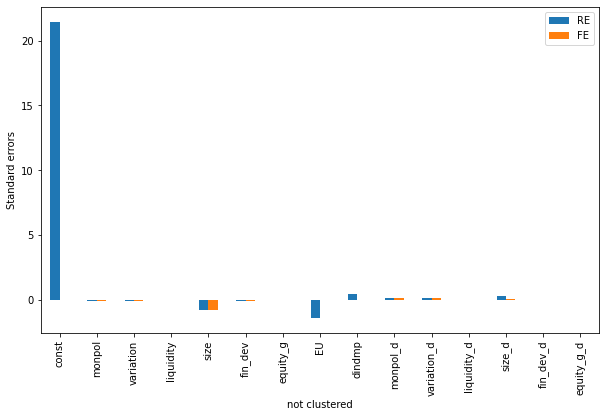

In [38]:
cross_compare(hw_8_RE, 'RE', hw_8_FE, 'FE', 'params').plot(figsize = (10,6), kind = 'bar', ylabel = 'Standard errors', xlabel = 'not clustered')

### ix Obtain the usual (nonrobust) Hausman test for comparing the RE and FE estimates of the Beta j. 

**See output below. The Hausman test, with 12 df is significant, with p = 0.0004.** 
** Based on this results, one would choose a fixed effects estimator.**

In [39]:
h = cross_compare(hw_8_FE, 'FE', hw_8_RE, 'RE', 'params').dropna()
d = h['FE']-h['RE']
d.name = 'difference' 
print(h.join(d))  # h.join(d).to_clipboard()

               FE    RE  difference
monpol      -0.07 -0.07       -0.00
variation   -0.09 -0.09        0.00
liquidity   -0.01 -0.01        0.00
size        -0.76 -0.76       -0.00
fin_dev     -0.03 -0.03       -0.00
equity_g     0.01  0.01        0.00
monpol_d     0.15  0.19       -0.04
variation_d  0.17  0.18       -0.01
liquidity_d -0.01 -0.02        0.00
size_d       0.10  0.30       -0.20
fin_dev_d    0.01  0.01        0.00
equity_g_d  -0.01 -0.01        0.00


`xtreg nim monpol* variation* liquidity* size* fin_dev* equity_g* EU dindmp, re`

`estimates store re`

`xtreg nim monpol* variation* liquidity* size* fin_dev* equity_g* EU dindmp , fe`

`estimates store fe`


`. hausman fe re`
                           
`b = consistent under Ho and Ha; obtained from xtreg`

`B = inconsistent under Ha, efficient under Ho; obtained from xtreg`

`Test:  Ho:  difference in coefficients not systematic`

`chi2(12)  = (b-B)'[(V_b-V_B)^(-1)](b-B)`

`          =       35.13`

`Prob>chi2 =      0.0004`

`(V_b-V_B is not positive definite)`

### (x) Obtain the robust, variable addition Hauman test. 

**In Stata, I ran:**

`egen monpolbar = mean(monpol), by(id)`

`xtreg nim monpol* variation* liquidity* size* fin_dev* equity_g* EU dindmp , re`

`estimates store re`

`xtreg nim monpol* variation* liquidity* size* fin_dev* equity_g* EU dindmp , fe`

`estimates store fe`


`Test:  Ho:  difference in coefficients not systematic`
`                 chi2(12) = (b-B)'[(V_b-V_B)^(-1)](b-B)`
`                         =       27.46`
`               Prob>chi2 =      0.0066`
`               (V_b-V_B is not positive definite)`

**that is, after ran the RE regression:**

`. xtreg nim monpol* variation* liquidity* size* fin_dev* equity_g* EU dindmp , re`

`Random-effects GLS regression                   Number of obs     =      1,888`

`Group variable: id                              Number of groups  =        236`

`R-sq:                                           Obs per group:`

`     within  = 0.0948                                         min =          8`

`     between = 0.2106                                         avg =        8.0`

`     overall = 0.1900                                         max =          8`

`                                                Wald chi2(15)     =     233.80`
`corr(u_i, X)   = 0 (assumed)                    Prob > chi2       =     0.0000`

`-------------------------------------------------------------------------------`

`          nim |      Coef.   Std. Err.      z    P>|z|     [95% Conf. Interval]`

`--------------+----------------------------------------------------------------`

`       monpol |  -.0736051   .3083328    -0.24   0.811    -.6779263    .5307161`

`   monpol_dmn |   .1615415     .30976     0.52   0.602    -.4455769    .7686598`

`    monpolbar |   .1868217   .0722757     2.58   0.010      .045164    .3284794`

`    variation |  -.0894023   .7230042    -0.12   0.902    -1.506465     1.32766`

`variation_dmn |   .1805577    .729715     0.25   0.805    -1.249658    1.610773`

`    liquidity |  -.0084411   .0244407    -0.35   0.730     -.056344    .0394619`

`liquidity_dmn |  -.0167482   .0246389    -0.68   0.497    -.0650397    .0315432`

`         size |  -.7642229    1.33579    -0.57   0.567    -3.382323    1.853877`

`     size_dmn |   .2806079   1.336923     0.21   0.834    -2.339713    2.900928`

`      fin_dev |  -.0281671   .0258485    -1.09   0.276    -.0788292     .022495`

`  fin_dev_dmn |    .014744    .026616     0.55   0.580    -.0374225    .0669104`

`     equity_g |   .0057875   .0152818     0.38   0.705    -.0241643    .0357392`

` equity_g_dmn |  -.0085447   .0154884    -0.55   0.581    -.0389014     .021812`

`           EU |  -.6141683   .4946819    -1.24   0.214    -1.583727    .3553904`

`       dindmp |   .5717715   .3825993     1.49   0.135    -.1781093    1.321652`

`        _cons |   20.33608    24.9821     0.81   0.416    -28.62794    69.30009`

`--------------+----------------------------------------------------------------`

`      sigma_u |  2.3403501`

`      sigma_e |  1.2837591`

`          rho |  .76870547   (fraction of variance due to u_i)`

`-------------------------------------------------------------------------------`

### What do you conclude about RE versus FE? 

The Chi^2 is still high, 27.46, versus 35.13.

### Does your conclusion differ from part (ix)?

The results are similar.


### (xi) Let monpol and interactive effect with liquidity, size it, and EU i and estimate the model by fixed effects. You can add the expressions

In [40]:
def f_homework(formula, data, tests, cov_type="unadjusted", cluster_entity=False, cluster_time=False):
    # FE
    cdic = {}
    if 'fe' in tests:
        try:
            mod = PanelOLS.from_formula(formula, data=data)
            fe_res = mod.fit(cov_type=cov_type, cluster_entity=cluster_entity, cluster_time=cluster_time)
            print(fe_res)
            cdic["FE"] = fe_res
        except Exception:
            pass
    for i in ['std-errors']:
        if len(tests) > 1:
            print(compare(cdic, precision=i))
    return cdic

In [41]:
formula = "nim ~ 1 + monpol + monpol:liquidity + monpol:size + monpol:EU + variation + liquidity + fin_dev + size + equity_g + EntityEffects"
hw_9  = f_homework(formula, df, ['fe'])

                          PanelOLS Estimation Summary                           
Dep. Variable:                    nim   R-squared:                        0.1278
Estimator:                   PanelOLS   R-squared (Between):             -0.0359
No. Observations:                1888   R-squared (Within):               0.1278
Date:                Mon, Mar 15 2021   R-squared (Overall):             -0.0073
Time:                        19:31:18   Log-likelihood                   -2986.9
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      26.752
Entities:                         236   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                  F(9,1643)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             26.752
                            

### Are the interactions individually or jointly significant? 

Yes

### What do you make of the very large coefficient on monpol? Does it have a useful meaning? 

It looks off, see output below what happens if molpol is demeaned.

### Does monpol have a larger or smaller effect of EU versus non-EU banks?

The interaction variable is significant and positive, so, apparently, yes.

I ran a reparameterized model with the demeaned *monpol* variable instead. See results below. Now the coefficient is lower. 

In [42]:
formula = "nim ~ 1 + monpol_d + monpol:liquidity + monpol:size + monpol:EU + variation + liquidity + fin_dev + size + equity_g + EntityEffects"
hw_9  = f_homework(formula, df.join(data_8nc['monpol_d']), ['fe'])

                          PanelOLS Estimation Summary                           
Dep. Variable:                    nim   R-squared:                        0.1115
Estimator:                   PanelOLS   R-squared (Between):              0.0205
No. Observations:                1888   R-squared (Within):               0.1115
Date:                Mon, Mar 15 2021   R-squared (Overall):              0.0364
Time:                        19:31:18   Log-likelihood                   -3004.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      22.899
Entities:                         236   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                  F(9,1643)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             22.899
                            